## Installing the required packages

In [2]:
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install -Uqq ipdb

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 64.6 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 75.0 MB/s 
     |████████████████████████████████| 895 kB 48.2 MB/s 
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 792 kB 5.0 MB/s 
     |████████████████████████████████| 374 kB 68.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.


## Importing required libraries

In [3]:
import os
import warnings
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

from itertools import chain
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_scheduler
from transformers.optimization import Adafactor, AdamW
from IPython.display import HTML, display

In [4]:
# Use this when working on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define the Class for Prompt Tuning

In [18]:
class T5PromptTuning(T5ForConditionalGeneration):
    def __init__(self, config):
          super().__init__(config)

    @classmethod
    def from_pretrained(cls, model_name_or_path: str, soft_prompt_path: str = None, number_tokens: int = None,
        initialize_from_vocab: bool = True, random_range: float = 0.5, **kwargs):
      
        model = super().from_pretrained(model_name_or_path, **kwargs)
  
        #  freeze the transformers model
        for param in model.parameters():
            param.requires_grad = False

        # if a saved soft prompt is loaded, use its embeddings
        if soft_prompt_path is not None: 
          model.set_soft_prompt_embeds(soft_prompt_path=soft_prompt_path)
        # else create a new soft prompt
        elif number_tokens is not None:
            print("Initializing soft prompt")
            model.initialize_soft_prompt(number_tokens=number_tokens, initialize_from_vocab=initialize_from_vocab, random_range=random_range)
        return model

    def set_soft_prompt_embeds(self, soft_prompt_path):
        self.soft_prompt = torch.load(
            soft_prompt_path, map_location=torch.device("cpu")
        )
        self.number_tokens = self.soft_prompt.shape[0]
        print(f"Set soft prompt. (number_tokens: {self.number_tokens})")

    def initialize_soft_prompt(self, number_tokens: int = 20, initialize_from_vocab: bool = True, random_range: float = 0.5):
        self.number_tokens = number_tokens
        if initialize_from_vocab:
            init_prompt_value = self.shared.weight[:number_tokens].clone().detach()
        else:
            init_prompt_value = torch.FloatTensor(number_tokens, self.config.d_model).uniform_(-random_range, random_range)

        print(init_prompt_value.shape)
        print(self.shared.weight.shape)

        # Initialize weight
        self.soft_prompt = torch.nn.parameter.Parameter(init_prompt_value)

    def get_soft_params(self):
        return self.soft_prompt

    # this method appends the learned prompt embeddings to the input ids of the input before the forward pass is calculated
    def append_learned_embedding_to_input(self, input_ids):
        inputs_embeds = self.shared(input_ids)
        
        if len(list(inputs_embeds.shape)) == 2: inputs_embeds = inputs_embeds.unsqueeze(0)

        # the shape of the tensor that will be returned will be: [batch_size, max_sequence_length, number_embeddings] -> [8, 600, 512]
        learned_embeds = self.soft_prompt.repeat(inputs_embeds.size(0), 1, 1)
        return torch.cat([learned_embeds, inputs_embeds], dim=1)

    # to make sure that padding token ids of the labels are not taken into account by the loss function
    # this method extends the labels tensor by elements that are ignored by the CrossEntropyLoss function
    # this can be done using the ignore_index value -100
    def extend_labels(self, labels, ignore_index=-100):
        if len(list(labels.shape)) == 1: labels = labels.unsqueeze(0)
        number_of_batches = labels.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+labels] that is filled with the ignore_index value (-100)
        return torch.cat([torch.full((number_of_batches, self.number_tokens), ignore_index).to(self.device), labels], dim=1)

    def extend_attention_mask(self, attention_mask):
        # prepend a new dimension (1) to the shape of attention_mask in case it is one dimensional
        if len(list(attention_mask.shape)) == 1: attention_mask = attention_mask.unsqueeze(0)

        # get the number of batches
        number_of_batches = attention_mask.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+attention_mask] that is filled with the ones
        return torch.cat([torch.full((number_of_batches, self.number_tokens), 1).to(self.device), attention_mask], dim=1)

    def save_soft_prompt(self, challenge_name, epochs):
        torch.save(self.soft_prompt, 'drive/MyDrive/MIwDL/soft_prompts/'+ 'soft_prompt_' + challenge_name + '_' + epochs + '_epochs.model')

## Load the Pre-trained model T5 and the tokenizer

In [ ]:
import torch as nn
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()


# Prompt-tuning
# number of prompt tokens
number_prompt_tokens = 100

# If set to true, the soft prompt will be initialized from the models vocabulary
# Otherwise, it will be randomly (uniformly in a range) initialized.
random_range = 0.5
init_from_vocab = True

try:
  del inputs_train_amr
  del inputs_test_amr
  del model_t5_small
  gc.collect()
except Exception:
  pass
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

tokenizer_t5_small = T5Tokenizer.from_pretrained('t5-small')

# Instantiate one T5 small model that should be trained on all the 3 datasets
#model_t5_small = T5PromptTuning.from_pretrained('t5-small', soft_prompt_path='drive/MyDrive/MIwDL/soft_prompts/soft_prompt_amr_90_epochs_2.model')
model_t5_small = T5PromptTuning.from_pretrained('t5-small', number_tokens=number_prompt_tokens, initialize_from_vocab=init_from_vocab)

#moving the models to device(GPU/CPU)
model_t5_small.to(dev)

## Preprocessing

In [35]:
load_no_duplicate_sets = True

# Load the datasets for the Web NLG 2020 challenge
train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/train/trainset_no_duplicate_inputs.csv')
test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/train/amr_train_no_duplicate_inputs.csv')
test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/test/amr_test_no_duplicate_inputs.csv')

# Load the datasets for the Web NLG 2020 challenge
#train_data_web_nlg = pd.read_csv('data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
#test_data_web_nlg = pd.read_csv('data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
#train_data_e2e = pd.read_csv('data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'data/e2e/train/trainset_no_duplicate_inputs.csv' )
#test_data_e2e = pd.read_csv('data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
#train_data_amr = pd.read_csv('data/amr/train/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'data/amr/train/amr_train_no_duplicate_inputs.csv')
#test_data_amr = pd.read_csv('data/amr/test/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'data/amr/test/amr_test_no_duplicate_inputs.csv')False)

In [36]:
# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)

test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

train_data_amr = train_data_amr.sort_values(by='input_text', ignore_index=True)
test_data_amr = test_data_amr.sort_values(by='input_text', ignore_index=True)

# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:] if not load_no_duplicate_sets else train_data_web_nlg.iloc[:len(train_data_web_nlg)-3,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:] if not load_no_duplicate_sets else test_data_web_nlg.iloc[:len(test_data_web_nlg)-7,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:] if not load_no_duplicate_sets else train_data_e2e.iloc[:len(train_data_e2e)-6,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:] if not load_no_duplicate_sets else test_data_e2e.iloc[:len(test_data_e2e)-6,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:] if not load_no_duplicate_sets else train_data_amr.iloc[:len(train_data_amr)-6,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:] if not load_no_duplicate_sets else test_data_amr.iloc[:len(test_data_amr)-3,:]

In [37]:
# Set the batch size and the number of training epochs
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 1640 --- 
--- Number of test  batches Web NLG: 74  --- 

--- Number of train batches E2E : 607 --- 
--- Number of test  batches E2E : 78  --- 

--- Number of train batches AMR : 168 --- 
--- Number of test  batches AMR : 18  --- 


In [38]:
def create_list_of_batches(batch_size, num_batches, data, tokenizer):
# Create List of batches for inputs and labels
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
#          input_batch.append('translate from Graph to Text: '+row['input_text']+'</s>')
#          label_batch.append(row['target_text']+'</s>')

          input_batch.append('translate from Graph to Text: '+row['input_text'])
          label_batch.append(row['target_text'])

        #input_batch=tokenizer.batch_encode_plus(input_batch,padding='longest',  return_tensors='pt', return_attention_mask=True)
        input_batch=tokenizer.batch_encode_plus(input_batch,padding=True, return_tensors='pt', return_attention_mask=True)
        #print('input_batch shape: ' + str(input_batch['input_ids'].shape))
        #input_batch_a=model_t5_small.append_learned_embedding_to_input(input_batch['input_ids'].to(dev))
        #print('input_batch shape: ' + str(input_batch.shape))
        
        #label_batch=tokenizer.batch_encode_plus(label_batch,padding='longest',  return_tensors='pt', return_attention_mask=True)
        
        label_batch=tokenizer.batch_encode_plus(label_batch,padding=True, return_tensors='pt', return_attention_mask=True)
        #label_batch=model_t5_small.append_learned_embedding_to_input(label_batch['input_ids'].to(dev))
        #print('label_batch shape: ' + str(label_batch.shape))

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

"""inputs_train_web_nlg, \
labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_train_web_nlg,
                                              data=train_data_web_nlg,
                                              tokenizer=tokenizer_t5_small)
inputs_test_web_nlg, \
labels_test_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_test_web_nlg,
                                              data=test_data_web_nlg,
                                              tokenizer=tokenizer_t5_small)
inputs_train_e2e, \
labels_train_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_train_e2e,
                                              data=train_data_e2e,
                                              tokenizer=tokenizer_t5_small)
inputs_test_e2e, \
labels_test_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_test_e2e,
                                              data=test_data_e2e,
                                              tokenizer=tokenizer_t5_small)"""
inputs_train_amr, \
labels_train_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_train_amr,
                                              data=train_data_amr,
                                              tokenizer=tokenizer_t5_small)
inputs_test_amr, \
labels_test_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_test_amr,
                                              data=test_data_amr,
                                              tokenizer=tokenizer_t5_small)


## Set the Optimizer for T5

In [39]:
def optimizer_adafactor(model, 
              lr=0.6,              # default values for adafactor
              eps=(1e-30, 1e-3),    # default values for adafactor
              clip_threshold=1.0,   # default values for adafactor 
              decay_rate=-0.8,      # default values for adafactor
              beta1=None,           # default values for adafactor 
              weight_decay=1e-5,     # default values for adafactor 
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        [model_t5_small.get_soft_params()],
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )
optimizer_t5 = optimizer_adafactor(model_t5_small)

## Training Routine Definition

In [40]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()

    #torch.cuda.empty_cache()

    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        #outputs = model(input_ids=inputs[i]['input_ids'], labels=labels[i]['input_ids'], attention_mask=inputs[i]['attention_mask'])
        outputs = model(inputs_embeds=model.append_learned_embedding_to_input(inputs[i]['input_ids']), labels=model.extend_labels(labels[i]['input_ids']), attention_mask= model.extend_attention_mask(inputs[i]['attention_mask']))
        
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

## Training Process

In [46]:
# Set the number of epochs to train
epochs = 30

Running epoch: 1


Epoch: 1 , Running loss: 1.410083619434209


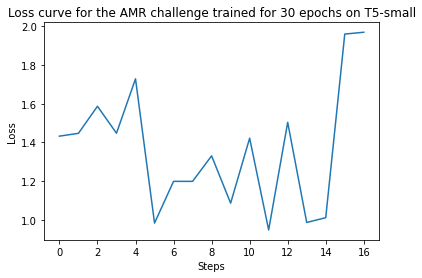

Running epoch: 2


Epoch: 2 , Running loss: 1.4079670200035685


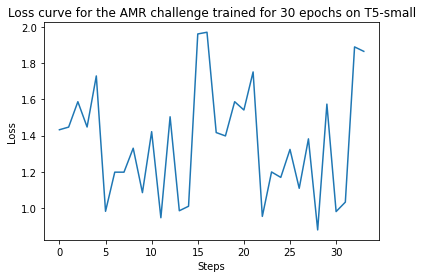

Running epoch: 3


Epoch: 3 , Running loss: 1.387821529237997


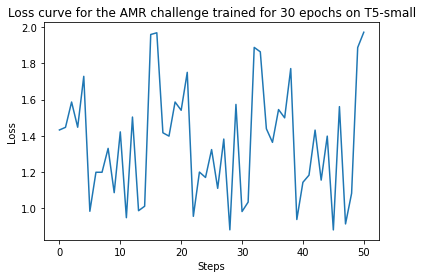

Running epoch: 4


Epoch: 4 , Running loss: 1.3805909373220944


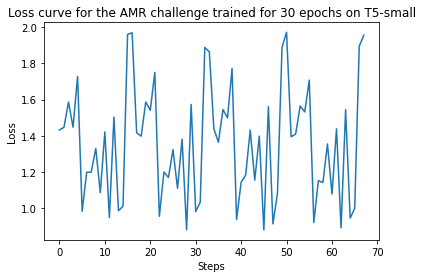

Running epoch: 5


Epoch: 5 , Running loss: 1.3691303861283122


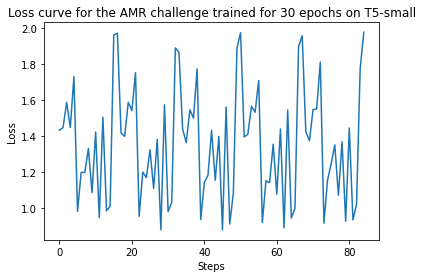

Running epoch: 6


Epoch: 6 , Running loss: 1.3721028160126436


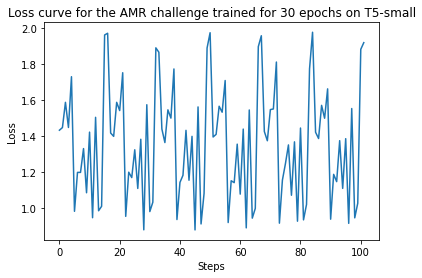

Running epoch: 7


Epoch: 7 , Running loss: 1.3564956172236375


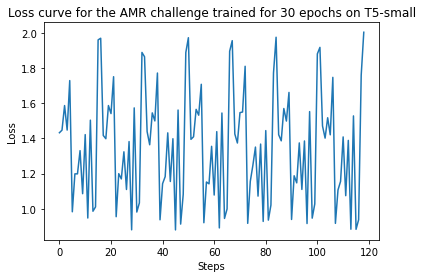

Running epoch: 8


Epoch: 8 , Running loss: 1.357973018128957


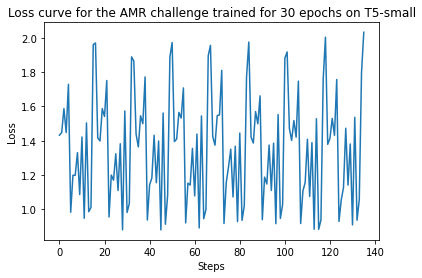

Running epoch: 9


Epoch: 9 , Running loss: 1.3535672624905903


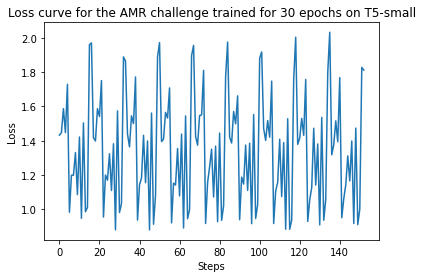

Running epoch: 10


Epoch: 10 , Running loss: 1.3412081048424755


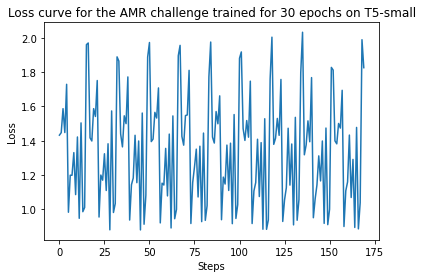

Running epoch: 11


Epoch: 11 , Running loss: 1.3449445469748407


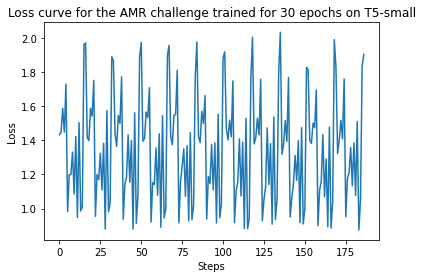

Running epoch: 12


Epoch: 12 , Running loss: 1.329390688001045


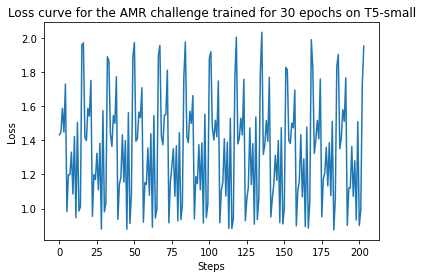

Running epoch: 13


Epoch: 13 , Running loss: 1.326918230081598


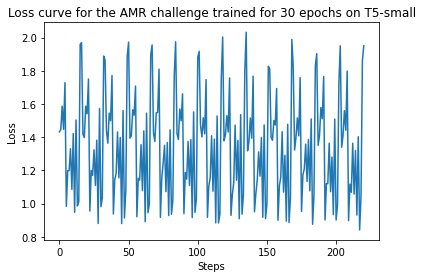

Running epoch: 14


Epoch: 14 , Running loss: 1.321349523518057


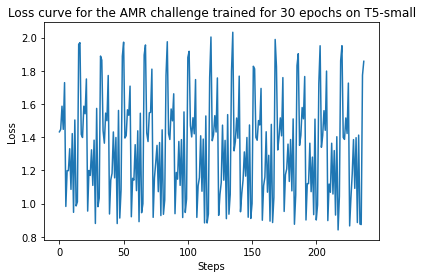

Running epoch: 15


Epoch: 15 , Running loss: 1.3151986013122259


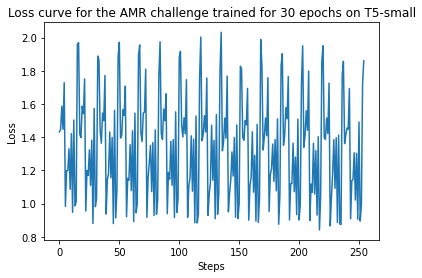

Running epoch: 16


Epoch: 16 , Running loss: 1.308846258114846


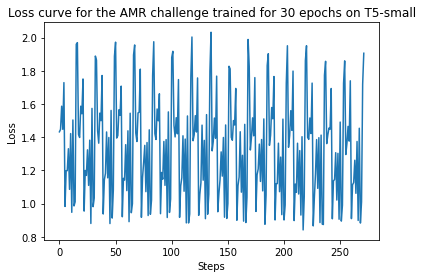

Running epoch: 17


Epoch: 17 , Running loss: 1.3080223725133


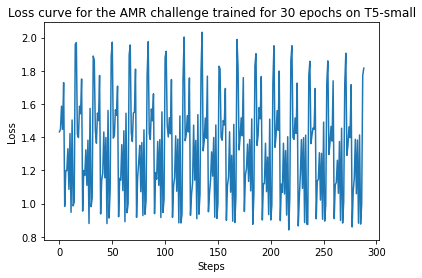

Running epoch: 18


Epoch: 18 , Running loss: 1.3156435881696997


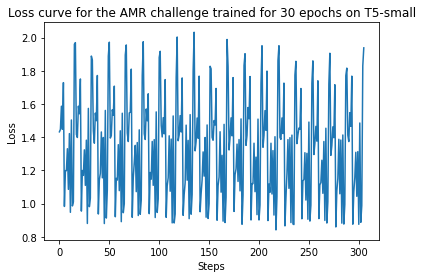

Running epoch: 19


Epoch: 19 , Running loss: 1.2934742366806382


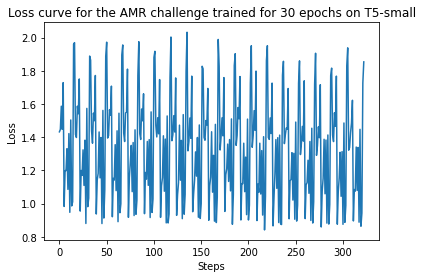

Running epoch: 20


Epoch: 20 , Running loss: 1.2955290220589155


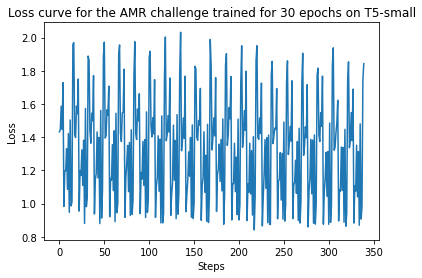

Running epoch: 21


Epoch: 21 , Running loss: 1.2899246478808069


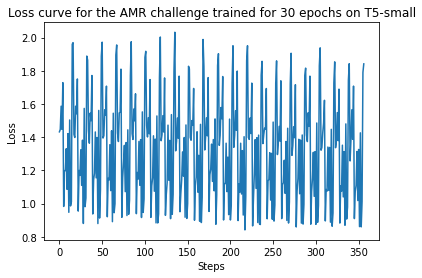

Running epoch: 22


Epoch: 22 , Running loss: 1.2929896612075114


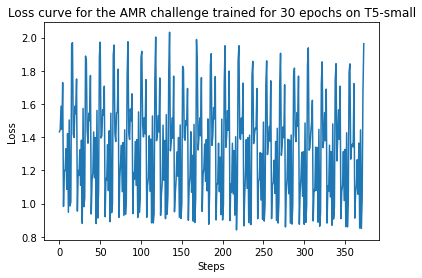

Running epoch: 23


Epoch: 23 , Running loss: 1.285183486927833


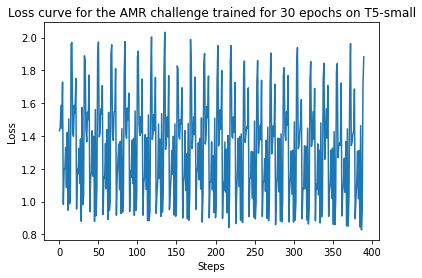

Running epoch: 24


Epoch: 24 , Running loss: 1.2781180329620838


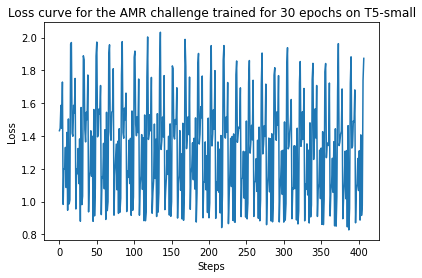

Running epoch: 25


Epoch: 25 , Running loss: 1.2761962881666564


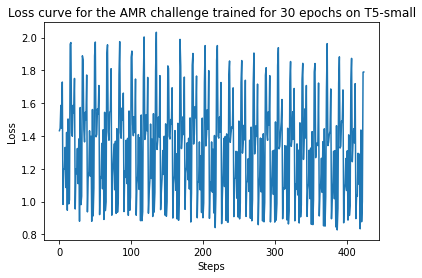

Running epoch: 26


Epoch: 26 , Running loss: 1.2749116721873481


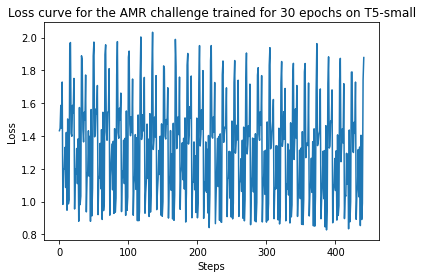

Running epoch: 27


Epoch: 27 , Running loss: 1.2698058854965937


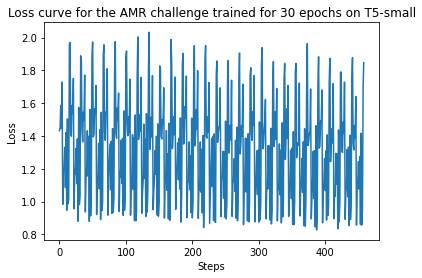

Running epoch: 28


Epoch: 28 , Running loss: 1.268340038534786


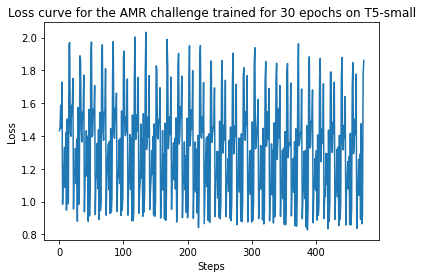

Running epoch: 29


Epoch: 29 , Running loss: 1.2698049328422971


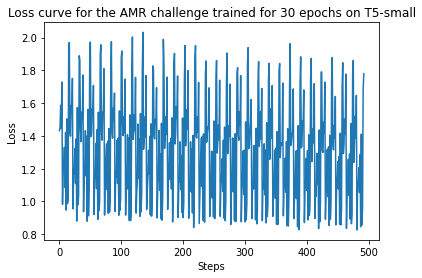

Running epoch: 30


Epoch: 30 , Running loss: 1.268507379417618


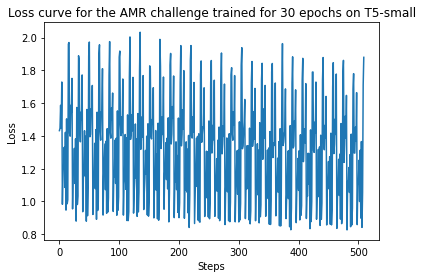

In [47]:
# Train T5 small on a mixture of all three challenges

model_t5_small = trainer(model=model_t5_small, 
                         num_batches=number_of_batches_train_amr, 
                         inputs=inputs_train_amr, 
                         labels=labels_train_amr,
                         optimizer=optimizer_t5,
                         challenge_name='AMR',
                         model_name='small')

In [ ]:
# Flush memory after interrupting training
# This will *hopefully* prevent a CUDA out-of-memory error.
#try:
#  del inputs_train_amr
#  del inputs_test_amr
#  gc.collect()
#except Exception:
#  pass
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

## Evaluate a Model

In [50]:
# use this method to generate text for each test input ids, then save the predictions
# in a file 'hypothesis' for web nlg and amr to later use the official evaluation script for the 
# challenges
def make_predictions(model, inputs_test, tokenizer, challenge_name):

  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      embeds = model.append_learned_embedding_to_input(inputs_test[i]['input_ids'])
      output = tokenizer.batch_decode(model.generate(inputs_embeds=embeds,
                                                     #do_sample=True, 
                                                     max_length=400,
                                                     #top_p=0.92,
                                                     #top_k=0,
                                                     bos_token_id=0,
                                                     pad_token_id=0,
                                                     eos_token_id=1,
                                                     use_cache=True,
                                                     attention_mask=model.extend_attention_mask(inputs_test[i]['attention_mask'])
                                                     ),
                                      skip_special_tokens=True,
                                      )
      print(output)
      model_predictions.append([x.replace('<pad>','').replace('</s>','').strip() for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  
  model.train()
  with open('drive/MyDrive/MIwDL/data/' + challenge_name + '/test/prompt_tuning_hypothesis/hypothesis', 'w') as file:
    for i in range(len(model_predictions)):
      file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])
  return model_predictions

In [51]:

model_predictions = make_predictions(model=model_t5_small,
                         inputs_test=inputs_test_amr,
                         tokenizer=tokenizer_t5_small,
                         challenge_name='amr')

['You allow me to go on by oneself.', 'That is so.', 'And the little prince, " said.', 'And the little prince, who was disappearing, did not appear to be.', 'And I love the stars.', 'And you have a little, "', 'And I made you present.', 'Sometimes you open that window.']
['And I would be a true man.', 'And you said to them, " and they made me laugh.', 'And she shuts her hair.', 'And the little prince changed his tear.', 'And you were contented with the pain of all the time.', 'And now, the year is gone.', 'And you are hurrying on this spot.', 'And I knew that I would ever hear more than any other.']
['And he laughed again.', 'And you looked up.', 'And you love all the stars.', 'It looked like you only looked at the stars.', 'And he said to himself to no more.', 'And you saw everything.', 'And he was sat down.', 'And all the stars are sweet.']
['And he took me.', 'And this is so important.', 'And she was so weak.', 'He answered, " a man, all.', 'You ask.', '" All the stars are blooming,

## Save the Soft Prompt

In [53]:
#torch.save(model_t5_small.soft_prompt, 'drive/MyDrive/MIwDL/soft_prompts/soft_prompt_amr_120_epochs.model')
model_t5_small.save_soft_prompt(challenge_name='amr', epochs=str(120))